# Session 2 - XGBoost Training

In this notebook we will follow some of the same workflows we discussed in Session 2, this time using strictly GPUs. For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument to test several data science techniques and machine learning algorithms.

**Author**: Jordan A. Caraballo-Vega, Caleb S. Spradlin  
**Release Date**: 2023.04.06  
**Last Modified**: 2023.04.06  

## Prerequisites

Before running all cells in this notebook, you will need to enable the GPU runtime from Google Colab.

First, click Runtime in in the top toolbar:

![image](https://miro.medium.com/v2/resize:fit:500/format:webp/1*eAg8XGh4S8GjNRPE-0RgbQ.png)

Then, click Change runtime type:

![image](https://miro.medium.com/v2/resize:fit:300/format:webp/1*gZHTwaB6M3Z-z6JyLyy4-g.png)

select GPU for Hardware accelerator:

![image](https://miro.medium.com/v2/resize:fit:400/format:webp/1*ZrrmH8Li3ulBnpr3y4qw3A.png)

Once the GPU Runtime has been set, run the following Python code to check GPU type:

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.


In [111]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2023-04-27 12:34:41--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py.4’

folium_helper.py.4  100%[===================>]   6.04K  --.-KB/s    in 0s      

2023-04-27 12:34:41 (46.3 MB/s) - ‘folium_helper.py.4’ saved [6189/6189]



In [112]:
!pip install datasets rasterio pyproj rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from huggingface_hub import snapshot_download

import xarray as xr
import xgboost as xgb
import rioxarray as rxr

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal
from osgeo import gdal_array

import folium
from folium import plugins
import folium_helper

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables
In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [114]:
# directory where we will output figures
FIGURE_OUTPUT_DIR = 'output'

# directory where we will output raster
RASTER_OUTPUT_DIR = 'output'

# directory where we will output our models
MODEL_OUTPUT_DIR = 'models'

# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# ratio of the dataset split for testing
TEST_RATIO = 0.2

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our models and visualizations.

In [115]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

Output any columns we will need to drop for training



In [116]:
colsToDrop

['x_offset', 'y_offset', 'year', 'julian_day']

In [117]:
colsToDropTraining

['x_offset',
 'y_offset',
 'year',
 'julian_day',
 'x_offset',
 'y_offset',
 'year',
 'julian_day',
 'tileID']

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:

- Read in data to a Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [118]:
%%time
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))

CPU times: user 431 ms, sys: 36 ms, total: 467 ms
Wall time: 2.06 s


After we download our dataset, we proceed to split it into training and test set. Note how the water column is set as the y feature and is dropped from the X features.

In [119]:
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

((800, 10), (200, 10))

Note how we further split our training dataset into training and validation dataset to monitor model performance during XGBoost training.

In [120]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    random_state=RANDOM_STATE,
    train_size=0.80,
)

Note how we now have a larger number of test samples, and smaller number of training samples. Which one to choose will depend on the problem you have in hand.

## 4. Training Preparation

Once we have our training and test data ready, we proceed to prepare for training our model. One technique often used to better validate the robustness of a machine learning model is K-fold cross validation.

Cross-validation is a statistical method used to estimate the skill of machine learning models. When using k-fold, the dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.

sckit-learn provides a useful feature to quickly setup these experiments. A K of 10 has been described by literature as the most effective value to decrease variance and nominally test performance. In this example, we will use a value of K = 5 for time purposes.

In [121]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [122]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


Like we did in the first exercise of this Session, we can look at some of the features of the data before proceeding to train.

In [123]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,640.0,1226.790625,1326.056292,8.0,241.00,898.0,1878.50,9222.0
sur_refl_b02_1,640.0,1600.375000,1583.392651,1.0,171.75,1436.5,2667.75,8837.0
sur_refl_b03_1,640.0,757.912500,1049.446733,-100.0,279.00,548.0,847.00,8909.0
sur_refl_b04_1,640.0,1038.996875,1103.524548,6.0,410.50,817.5,1297.25,9162.0
sur_refl_b05_1,640.0,1961.509375,1481.292677,-92.0,551.00,1802.5,3203.25,6382.0
sur_refl_b06_1,640.0,1914.764062,1550.032855,51.0,504.00,1441.0,3167.00,6610.0
sur_refl_b07_1,640.0,1568.620312,1406.276378,0.0,306.50,1119.5,2585.50,6128.0
ndvi,640.0,129.134375,2519.341228,-9493.0,-1475.00,746.5,1763.00,8587.0
ndwi1,640.0,-2207.950000,3437.366950,-9862.0,-4380.50,-1538.0,-689.00,8823.0
ndwi2,640.0,-739.209375,3884.652229,-9692.0,-2540.00,-682.0,951.00,10000.0


We can also use thresholding methods based on our physical knowledge to extract interesting features of outliers that we might want to visualize later when evaluating the model.

## 5. Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages. Some of the most useful parameters to know about from the XGBoost are:
- n_estimators: number of trees in the forest
- max_depth: the maximum depth of a tree
- objective: it defines the loss function to be minimized. Most commonly used values are given below -
  - reg:squarederror : regression with squared loss.
  - reg:squaredlogerror: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2. - All input labels are required to be greater than -1.
  - reg:logistic : logistic regression
  - binary:logistic : logistic regression for binary classification, output probability
  - binary:logitraw: logistic regression for binary classification, output score before logistic transformation
  - binary:hinge : hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
  - multi:softmax : set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
  - multi:softprob : same as softmax, but output a vector of ndata nclass, which can be further reshaped to ndata nclass matrix. The result contains predicted probability of each data point belonging to each class.

In [124]:
hyperparameters = {'objective': 'binary:logistic',
                   'n_estimators':100,
                   'base_score': None,
                   'booster': None,
                   'colsample_bylevel': None,
                   'colsample_bynode': None,
                   'colsample_bytree': None,
                   'gamma': None,
                   'gpu_id': None,
                   'interaction_constraints': None,
                   'learning_rate': 0.003,
                   'max_delta_step': None,
                   'max_depth': None,
                   'min_child_weight': None,
                   'monotone_constraints': None,
                   'n_jobs': -1,
                   'num_parallel_tree': None,
                   'random_state': None,
                   'reg_alpha': None,
                   'reg_lambda': None,
                   'scale_pos_weight': None,
                   'subsample': None,
                   #'tree_method': '',
                   'validate_parameters': None,
                   'verbosity': None
}

Here we define the classifier by including the hyperparameters we defined above.

In [125]:
classifier = xgb.XGBClassifier(**hyperparameters)

We can then define which metrics to use to monitor model performance during training.

In [126]:
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metric = ["error","auc"]

## 5.1 k-Fold fitting

Then we can proceed to train our model using the k-Fold approach. We perform K iterations, and by the end of the iterations we select the best performing model, and calculate the average score across all of them.

In [127]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361
 362 363 364 365 366 367 368 369 370 371 372 

Here we can calculate the average score, and the score of the best model.

In [128]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.9640625
Best accuracy score: 0.984375


## 5.2 Regular fitting

We can also train our model without doing any k-Fold cross-validation. We can simply define our classifier, and perform the fit operation directly on the training dataset.

In [129]:
classifier = xgb.XGBClassifier(**hyperparameters)

In [130]:
eval_set = [(X_train, y_train), (X_val, y_val)]
eval_metric = ["error","auc"]

In [131]:
%%time
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.01406	validation_0-auc:0.99624	validation_1-error:0.01875	validation_1-auc:0.99233
[1]	validation_0-error:0.01406	validation_0-auc:0.99626	validation_1-error:0.01875	validation_1-auc:0.99233
[2]	validation_0-error:0.01250	validation_0-auc:0.99624	validation_1-error:0.03125	validation_1-auc:0.99233
[3]	validation_0-error:0.01250	validation_0-auc:0.99625	validation_1-error:0.03125	validation_1-auc:0.99233
[4]	validation_0-error:0.01250	validation_0-auc:0.99622	validation_1-error:0.01875	validation_1-auc:0.99233
[5]	validation_0-error:0.01250	validation_0-auc:0.99625	validation_1-error:0.01875	validation_1-auc:0.99233
[6]	validation_0-error:0.01250	validation_0-auc:0.99623	validation_1-error:0.01875	validation_1-auc:0.99233
[7]	validation_0-error:0.01406	validation_0-auc:0.99622	validation_1-error:0.03125	validation_1-auc:0.99233
[8]	validation_0-error:0.01406	validation_0-auc:0.99624	validation_1-error:0.03125	validation_1-auc:0.99233
[9]	validation_0-error:0.014

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Then we can simply compute the score from the model output.

In [132]:
score = classifier.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.98


## 6. Model testing and training/testing data validation

Once we have trained our model we can proceed to use the best model and perform testing and validation using our dataset.

### 6.1 Get model metrics

We can calculate accuracy metrics from our model using the test dataset, but we can also output prediction probabilities to understand the drivers behind the model performance.

In [133]:
classifier = bestModel

In [134]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.975

Note how easy it is to perform predictions once we have datasets in dataframe format.

In [135]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

Here we can take the prediction probabilities straight out of the model so we can visualize them. These are important since they tell use the confidence of our model when perform the classification.

In [136]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### 6.2 Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

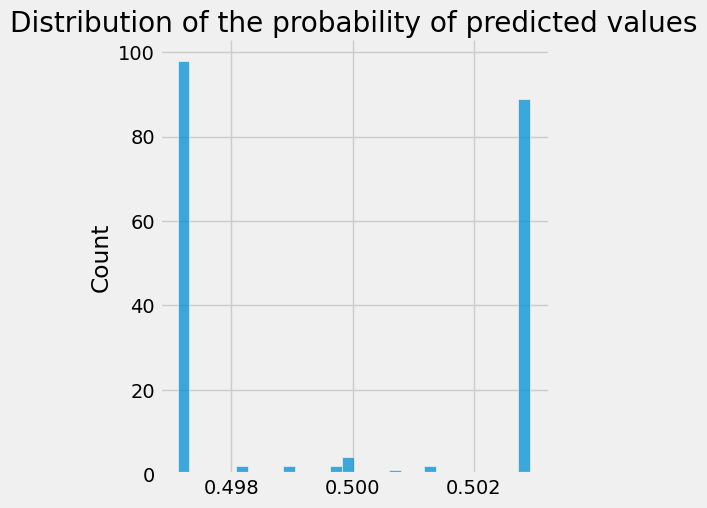

In [137]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [138]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

## 6.3 Additional Metrics 

We can compute additional metrics to understand model performance related to producer and user accuracy.

In [139]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       105
           1       0.99      0.96      0.97        95

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

Test Recall
-------------------------------------------------------
0.9904761904761905
Confusion Matrix
-------------------------------------------------------
[[104   1]
 [  4  91]]


We can also look at Receiver Operating Characteristic (ROC) plots to understand the performance of the model across all samples between True Positive and False Positive rates.

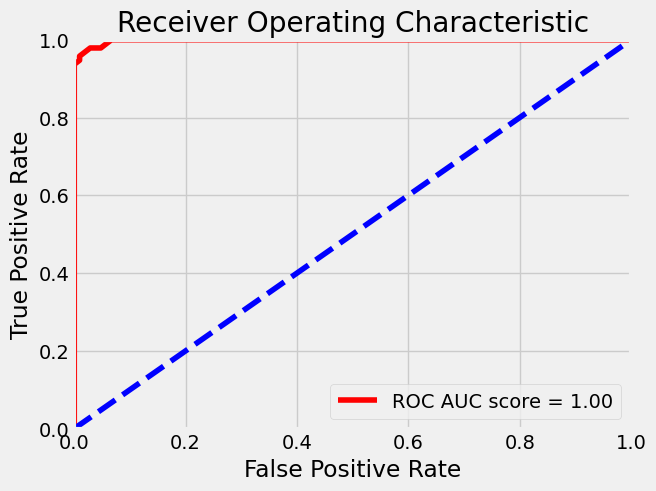

In [140]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 6.4 Permutation Importance

Another important metric to understand model performance is to evaluate permutation importance, particularly focused on the importance of each feature in the training and inference of the model.

In [141]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 871 ms, sys: 9.74 ms, total: 881 ms
Wall time: 674 ms


Let's look at some of the variables of most importance during the training and inference of the model.

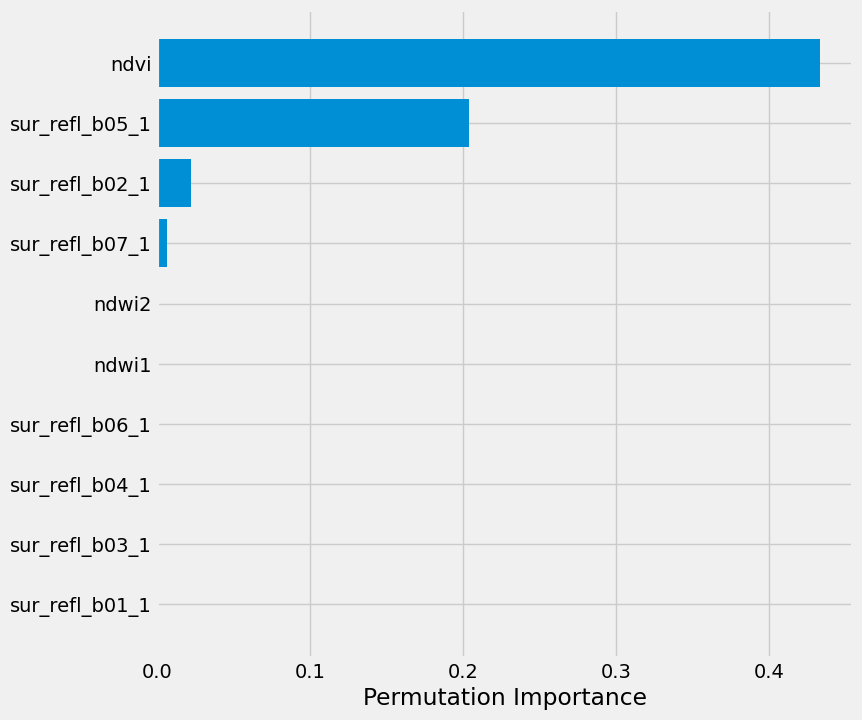

In [142]:
png_save_path = 'mw_{}_{}_rf_{}_permutation_importance.png'.format(
    score,
    hyperparameters['n_estimators'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

Garbage collection

In [143]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## 7. Save the model for future use

We can then save our model for future use so we can apply it or share it elsewhere. The only prerequisite would be for the input dataset to be in the same format as the input training data.

In [144]:
model_save_path = 'mw_{}_{}_{}_2.0.0_tuned_{}.sav'.format(score,
                                                             hyperparameters['n_estimators'],
                                                             'cpu',
                                                             datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: models/mw_0.975_100_cpu_2.0.0_tuned_2023_04_27_12_34.sav
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


['models/mw_0.975_100_cpu_2.0.0_tuned_2023_04_27_12_34.sav']

## 8. Raster Inference

## 8.1 Data download

Here we can proceed to perform inference using raster objects. The first step is to download some imagery to test with.

In [145]:
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Then we can select all individual band TIF images and stack them to form the raster needed as input to the model. Note that you can skip this step if you already have your raster that includes all bands.

In [146]:
fileList = sorted(glob.glob(os.path.join(powell_dataset, 'MOD09GA*.tif')))
fileList

['/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/4f0bdc00cdf802db50357185b3287f1d66a9e388/MOD09GA.A2001155.h09v05.061.2020061221201.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/4f0bdc00cdf802db50357185b3287f1d66a9e388/MOD09GA.A2006207.h18v03.061.2020267103537.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/4f0bdc00cdf802db50357185b3287f1d66a9e388/MOD09GA.A2006218.h12v09.061.2020268185436.tif']

Then we can perform some feature engineering on the fly to add some additional column features such as NDVI, NDWI1, and NDWI2.

In [147]:
def readRastersToArray(raster_filename):
    """
    Here we read and reproject the tiles, then do some feature
    engineering to calculate individual indices
    """
    raster = rxr.open_rasterio(raster_filename)
    raster = raster.rio.reproject("EPSG:3857")

    n_bands = raster.shape[0]

    ndvi = (((raster[1, :, :] - raster[0, :, :]) / (raster[1, :, :] + raster[0, :, :])) * 10000).expand_dims(dim="band", axis=0)
    ndvi.coords['band'] = [n_bands + 1]

    ndwi1 = (((raster[1, :, :] - raster[5, :, :]) / (raster[1, :, :] + raster[5, :, :])) * 10000).expand_dims(dim="band", axis=0)
    ndwi1.coords['band'] = [n_bands + 2]
  
    ndwi2 = (((raster[1, :, :] - raster[6, :, :]) / (raster[1, :, :] + raster[6, :, :])) * 10000).expand_dims(dim="band", axis=0)
    ndwi2.coords['band'] = [n_bands + 3]
    return xr.concat([raster, ndvi, ndwi1, ndwi2], dim='band')

def predictRaster(dataframe, colsToDrop=None):
    """
    Function given a raster in the form of a 
    GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = dataframe.drop(columns=colsToDrop) if colsToDrop else dataframe
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs
  
def save_raster(filename, predicted_raster, output_filename, prediction_nodata=255, epsg="EPSG:3857"):
    """
    Here we take the output from the model
    and save it into GTiff format
    """
    if predicted_raster.dtype == 'float32':
      prediction_nodata = -9999

    # open raster object
    raster_obj = rxr.open_rasterio(filename)
    raster_obj = raster_obj.rio.reproject(epsg).fillna(-9999)
    raster_obj.attrs['_FillValue'] = -9999
    raster_array = raster_obj.values

    # Drop raster band to allow for a merge of mask
    raster_obj = raster_obj.drop(
        dim="band",
        labels=raster_obj.coords["band"].values[1:],
    )
    predicted_raster[raster_array[0, :, :] == -9999] = prediction_nodata

    # Get metadata to save raster
    prediction = xr.DataArray(
        np.expand_dims(predicted_raster, axis=0),
        name='output',
        coords=raster_obj.coords,
        dims=raster_obj.dims,
        attrs=raster_obj.attrs
    ).fillna(prediction_nodata)
    prediction.attrs['_FillValue'] = prediction_nodata

    # Add metadata to raster attributes
    prediction.attrs['long_name'] = ('output')

    # Set nodata values on mask
    nodata = prediction.rio.nodata
    prediction.rio.write_nodata(
        prediction_nodata, encoded=True, inplace=True)

    # Save output raster file to disk
    prediction.rio.to_raster(
        output_filename,
        BIGTIFF="IF_SAFER",
        compress='LZW',
        driver='GTiff',
        dtype='int16'
    )
    return

## 8.2 Perform Inference

We can then iterate over each raster we want to predict and output the predictions and probabilities into a single GTiff.

In [148]:
%%time

# iterate over each filename
for filename in fileList:

  print("Filename: ", filename)

  # read raster into array
  raster_array = readRastersToArray(filename).values
  print("Input raster shape: ", raster_array.shape)

  # flatten the raster for prediction
  flatten_raster = raster_array.reshape((raster_array.shape[0], raster_array.shape[1]*raster_array.shape[2])).transpose()
  print("Flatten raster shape: ", flatten_raster.shape)

  # perform prediction, and reshape raster and probabilities
  predicted_raster, predicted_probability = predictRaster(flatten_raster)
  predicted_raster = predicted_raster.reshape((raster_array.shape[1], raster_array.shape[2]))
  predicted_probability = predicted_probability[:, 1].reshape((raster_array.shape[1], raster_array.shape[2]))
  print("Output predictions shape: ", predicted_raster.shape, predicted_probability.shape)

  # saved output into raster
  save_raster(filename, predicted_raster, f'{Path(filename).stem}-prediction.tif')
  save_raster(filename, predicted_probability, f'{Path(filename).stem}-probability.tif')



Filename:  /root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/4f0bdc00cdf802db50357185b3287f1d66a9e388/MOD09GA.A2001155.h09v05.061.2020061221201.tif
Input raster shape:  (10, 1487, 3051)
Flatten raster shape:  (4536837, 10)
Making predictions from raster
Output predictions shape:  (1487, 3051) (1487, 3051)
Filename:  /root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/4f0bdc00cdf802db50357185b3287f1d66a9e388/MOD09GA.A2006207.h18v03.061.2020267103537.tif
Input raster shape:  (10, 2540, 2895)
Flatten raster shape:  (7353300, 10)
Making predictions from raster
Output predictions shape:  (2540, 2895) (2540, 2895)
Filename:  /root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/4f0bdc00cdf802db50357185b3287f1d66a9e388/MOD09GA.A2006218.h12v09.061.2020268185436.tif
Input raster shape:  (10, 2500, 2718)
Flatten raster shape

## 9. Visualize your output

We can then proceed to visualize the output of our model in an interactive map. But first, we need to fix the projection in order to properly display the map using the interactive visualization package called folium.

In [149]:
predicted_filenames = sorted(glob.glob('*prediction.tif'))
predicted_probability_filenames = sorted(glob.glob('*probability.tif'))
predicted_filenames

['MOD09GA.A2001155.h09v05.061.2020061221201-prediction.tif',
 'MOD09GA.A2006207.h18v03.061.2020267103537-prediction.tif',
 'MOD09GA.A2006218.h12v09.061.2020268185436-prediction.tif']

(array([0, 1, 3], dtype=int16), array([2197312,   16677, 2322848]))


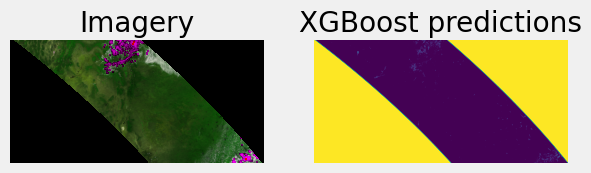

(array([0, 1, 3], dtype=int16), array([3661727, 2823187,  868386]))


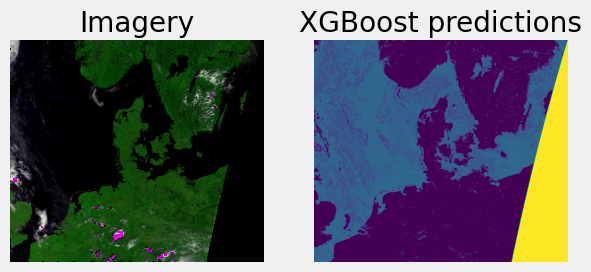

(array([0, 1, 3], dtype=int16), array([6118323,  132092,  544585]))


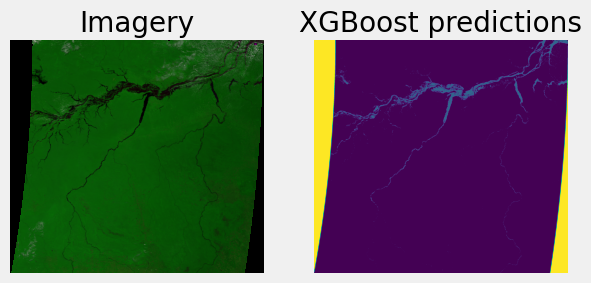

In [150]:
for data_filename, predicted_filename in zip(fileList, predicted_filenames):

    data = rxr.open_rasterio(data_filename).rio.reproject("EPSG:3857")
    data = np.moveaxis(data[:3,:,:].values, 0, -1)

    mask = np.squeeze(rxr.open_rasterio(predicted_filename).values)
    mask[mask == 255] = 3
    print(np.unique(mask, return_counts=True))

    # plot the imagery and the prediction mask for comparison
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(data / 10000)
    axarr[0].set_title('Imagery')
    axarr[1].imshow(mask)
    axarr[1].set_title('XGBoost predictions')

    axarr[0].axis('off')
    axarr[1].axis('off')

    plt.show()

Define the folium map for visualization:

In [151]:
m = folium.Map(tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 10, attr='Google')

Then iterate over each output prediction and add it as a layer to our map.

In [152]:
for filename in predicted_filenames:
    mask_3857 = folium_helper.reproject_to_3857(filename)
    mask_d = folium_helper.get_bounds(mask_3857)
    mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
    folium_helper.cleanup(mask_3857)
    print("Unique values in mask: ", np.unique(mask_b1))
    mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
    print("Unique values in mask after cleanup: ", np.unique(mask_b1))
    zeros = np.zeros_like(mask_b1)
    mask_rgb = np.dstack((mask_b1, zeros, zeros))

    m.add_child(
        folium_helper.get_overlay(
            mask_rgb, mask_d,
            f'Water classification {Path(filename).stem}',
            opacity=0.7
        )
    )

Transform: | 916.18, 0.00,-13078554.72|
| 0.00,-916.18, 4865942.28|
| 0.00, 0.00, 1.00|
Width: 3051 Height: 1487
Unique values in mask:  [  0   1 255]
Unique values in mask after cleanup:  [0 1]
Transform: | 769.16, 0.00,-0.00|
| 0.00,-769.16, 8399737.89|
| 0.00, 0.00, 1.00|
Width: 2895 Height: 2540
Unique values in mask:  [  0   1 255]
Unique values in mask after cleanup:  [0 1]
Transform: | 447.54, 0.00,-6782206.40|
| 0.00,-447.54, 0.00|
| 0.00, 0.00, 1.00|
Width: 2718 Height: 2500
Unique values in mask:  [  0   1 255]
Unique values in mask after cleanup:  [0 1]


From there we can define a basemap and the region of interest for our map to initially start.


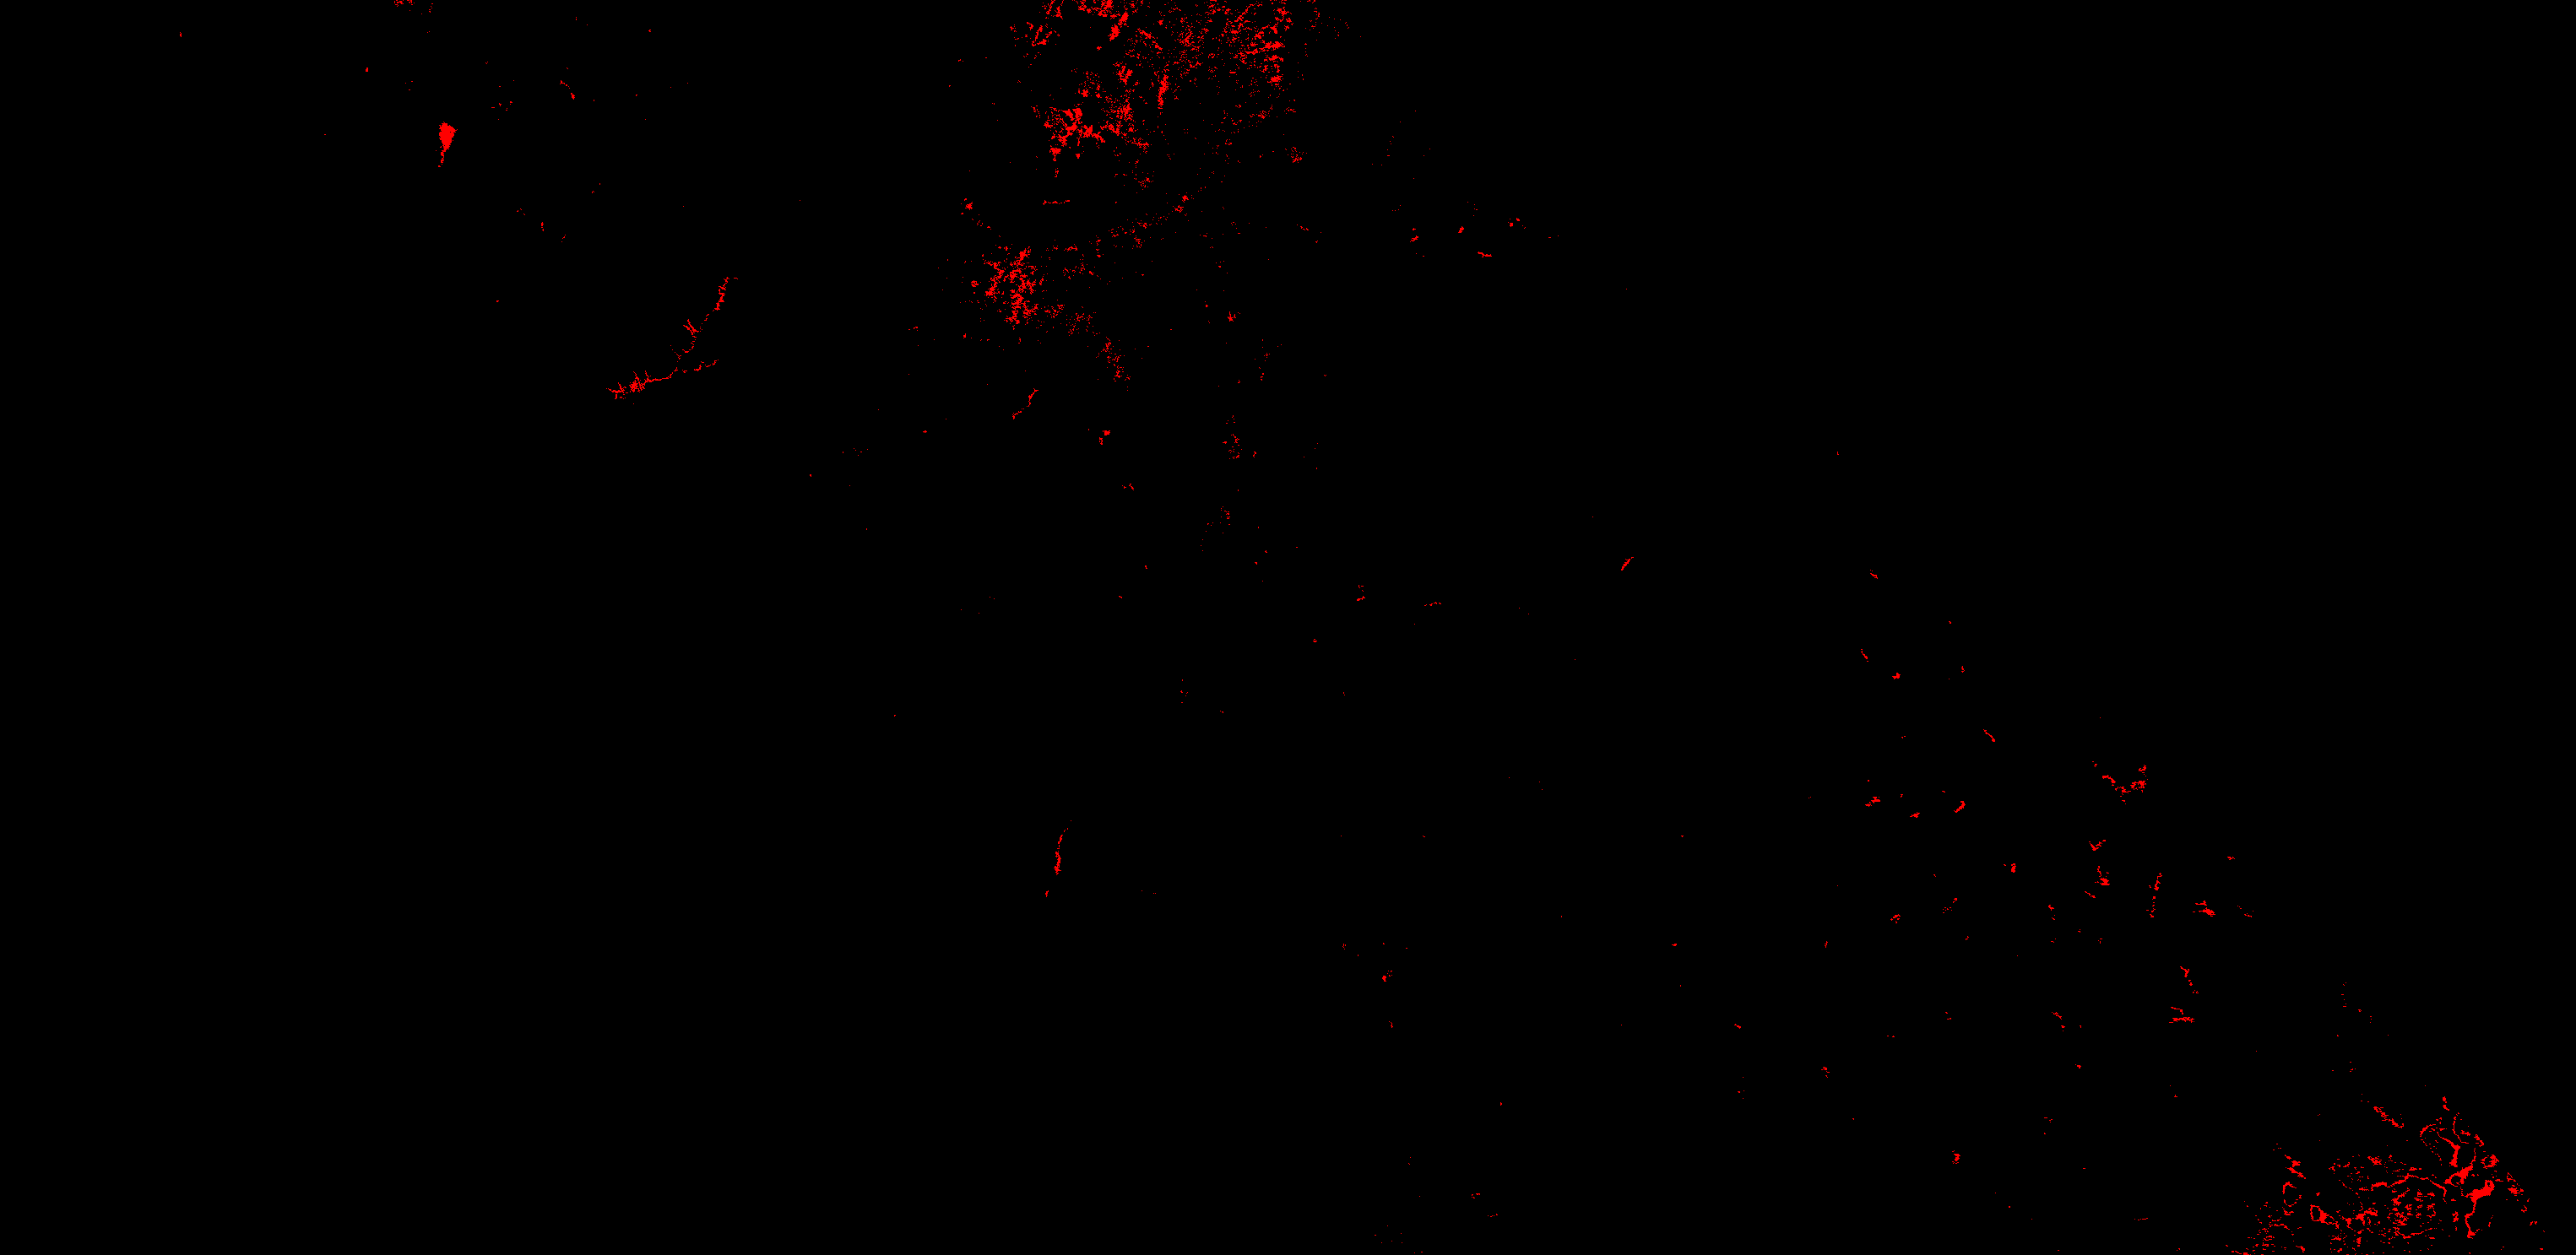
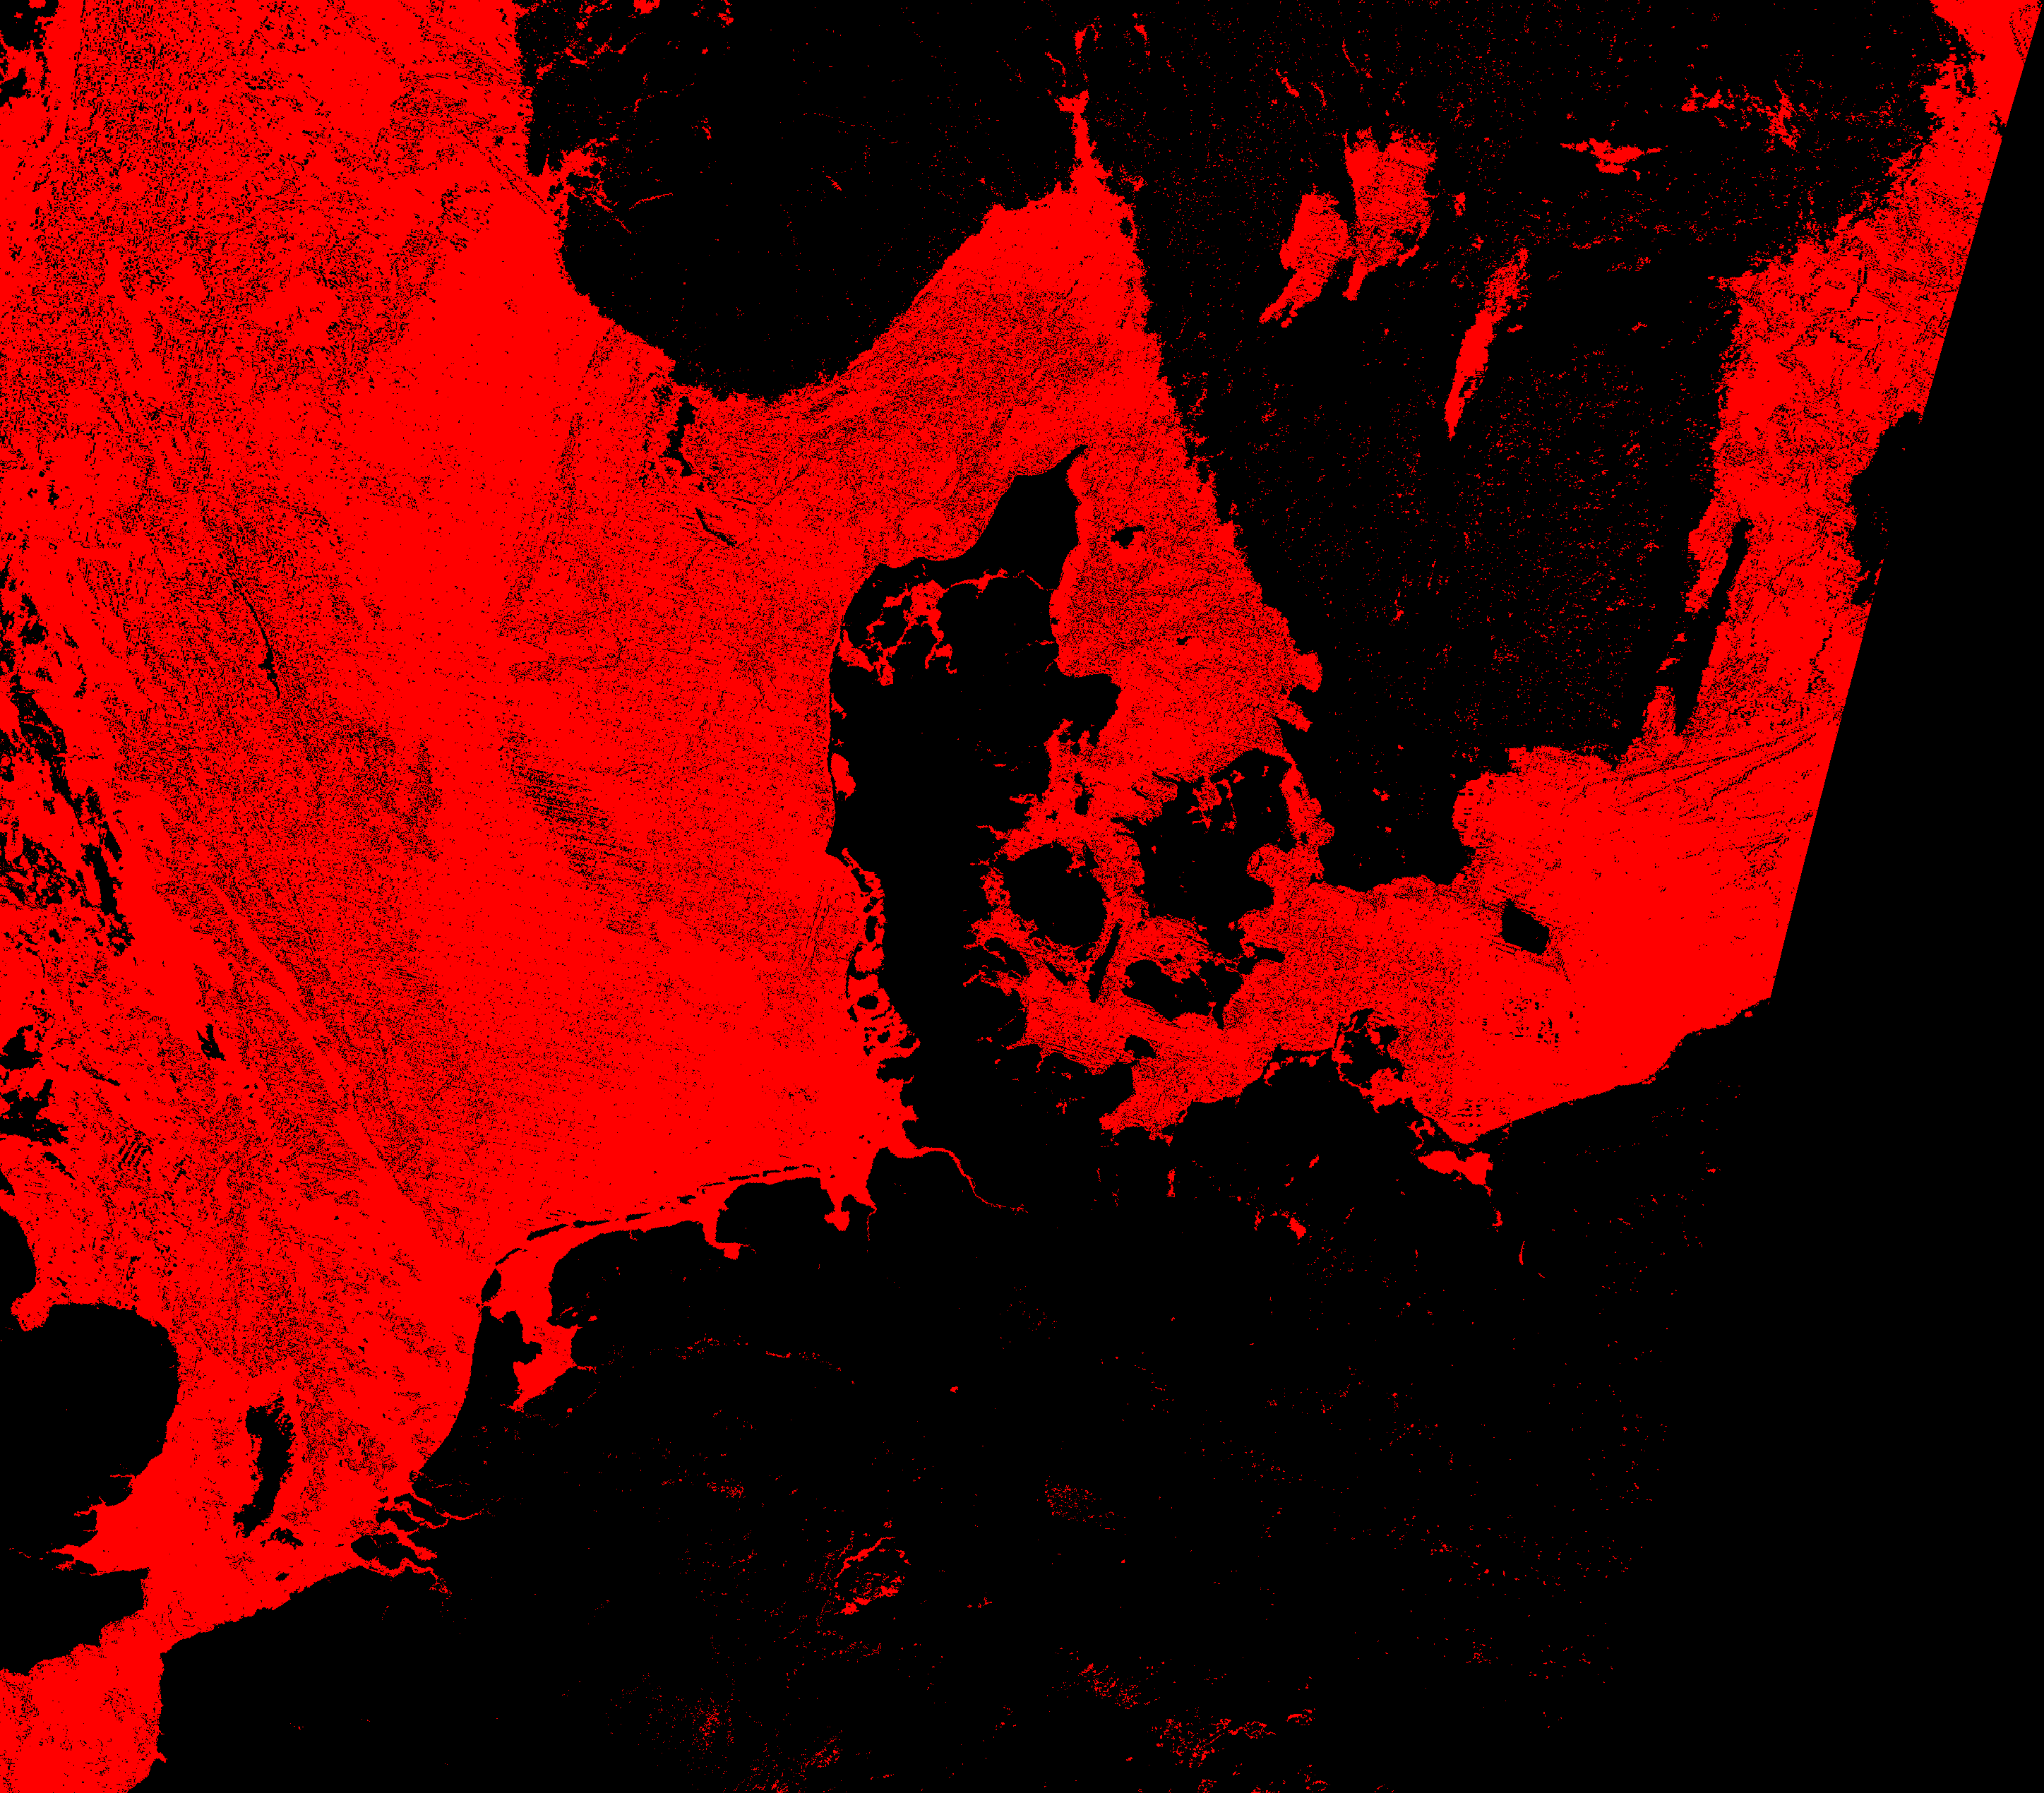
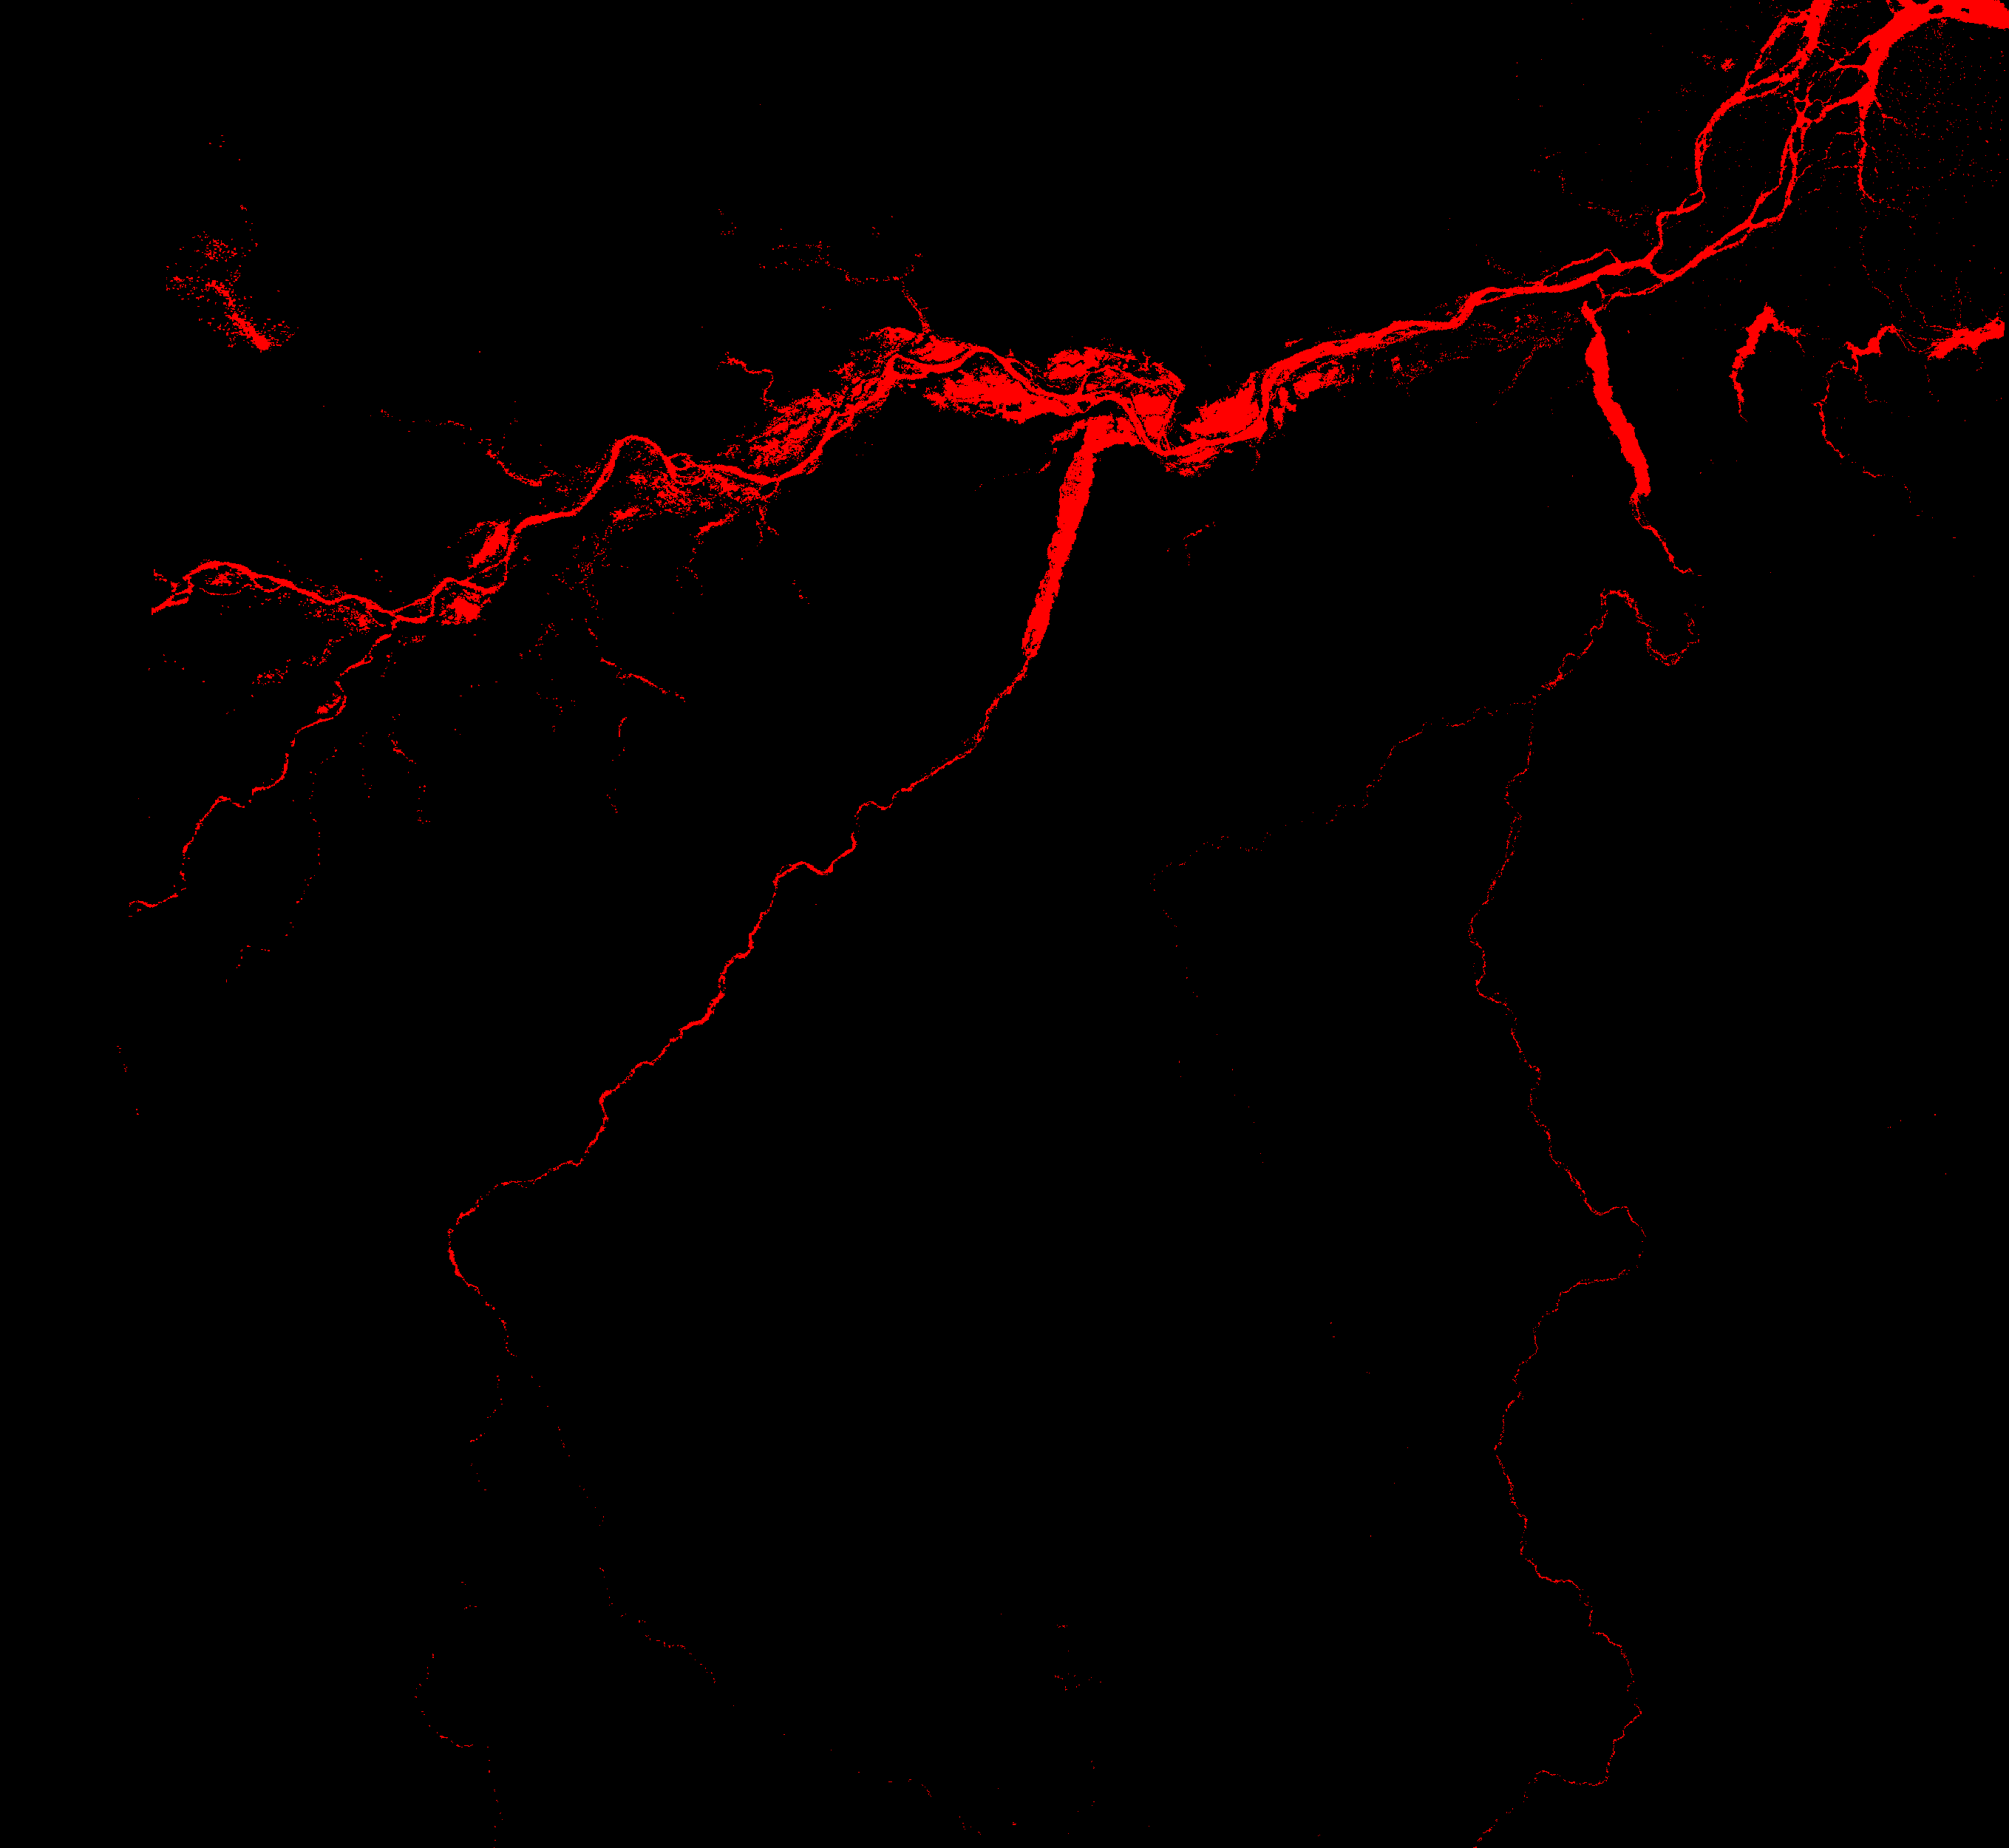

In [153]:
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())
m

## 10. Some Questions to Practice Before Final Assignment

- What is the data type of our surface reflectance features?
- What are the basic steps in any Exploratory Data Analysis workflow?
- What are the most common data types used in machine learning?
- What are examples of visualizations to analyze data distributions? Why is this important?
- What are two techniques to handle imbalanced datasets?
- What steps are missing from Session 2 assignment to make predictions production ready?